# Batch process Equivalent Widths with $\mu$ler

The goal of this notebook is to distill our analysis into a programmatic loop over many spectra and save the Equivalent Width (EW) and its uncertainty to a results table.  The table will be in the form of a pandas dataframe, which we'll then save as a csv file.

In [32]:
import numpy as np
import pandas as pd
import os
import glob
from astropy.io import fits
from astropy.time import Time
from tqdm.auto import tqdm
import astropy.units as u

import warnings

from pandas.core.common import SettingWithCopyWarning
%config InlineBackend.figure_format = 'retina'

warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

Reading the files:

In [33]:
goldilocks_files = sorted(glob.glob('C:/Users/jojoa/GitHub/disperse/data/HPF/Helium-transit-data/**/Goldilocks*.fits', recursive=True))

In [34]:
target_name = 'HAT-P-67b'
matchers = [target_name,'20200615'] #if file has date and name, pull it
matching = [s for s in goldilocks_files if all(xs in s for xs in matchers)]
goldilocks_files = matching

In [35]:
from muler.hpf import HPFSpectrum

In [36]:
fn = goldilocks_files[0]
fn

'C:/Users/jojoa/GitHub/disperse/data/HPF/Helium-transit-data\\HAT-P-67b\\in-transit\\20200615\\Goldilocks_20200615T031252_v1.0_0023.spectra.fits'

In [37]:
raw_spectrum = HPFSpectrum(file=fn,order=19)

(0.1, 1.7)

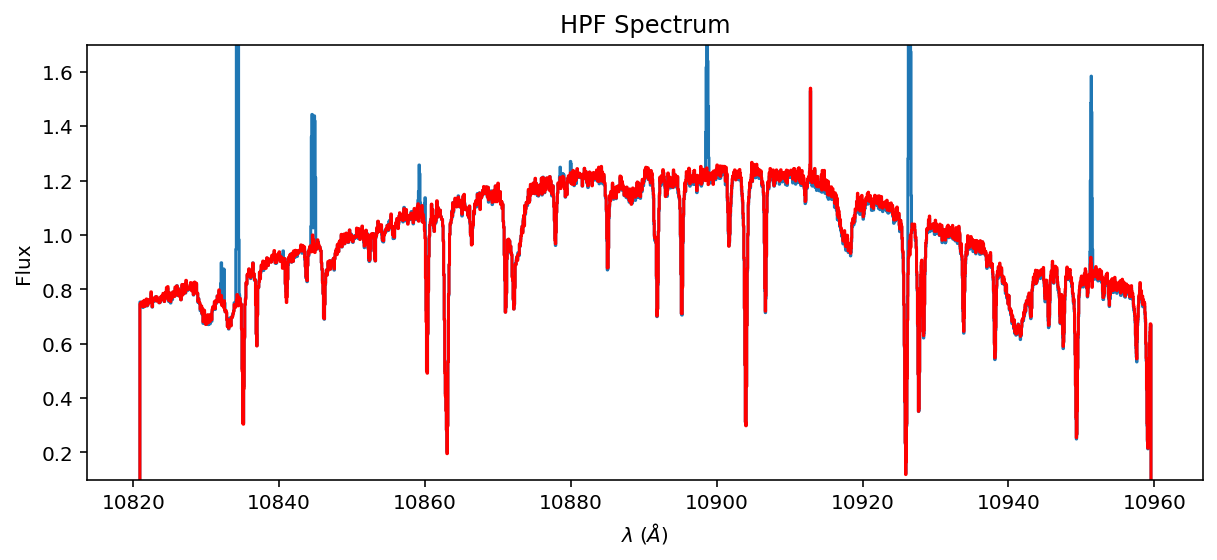

In [38]:
ax = raw_spectrum.normalize().plot() #spectrum with sky lines
raw_spectrum.sky_subtract(method='vector').normalize().plot(ax=ax,color='r') #sky subtracted spectrum
ax.set_ylim(0.1,1.7)

<AxesSubplot:title={'center':'HPF Spectrum'}, xlabel='$\\lambda \\;(\\AA)$', ylabel='Flux'>

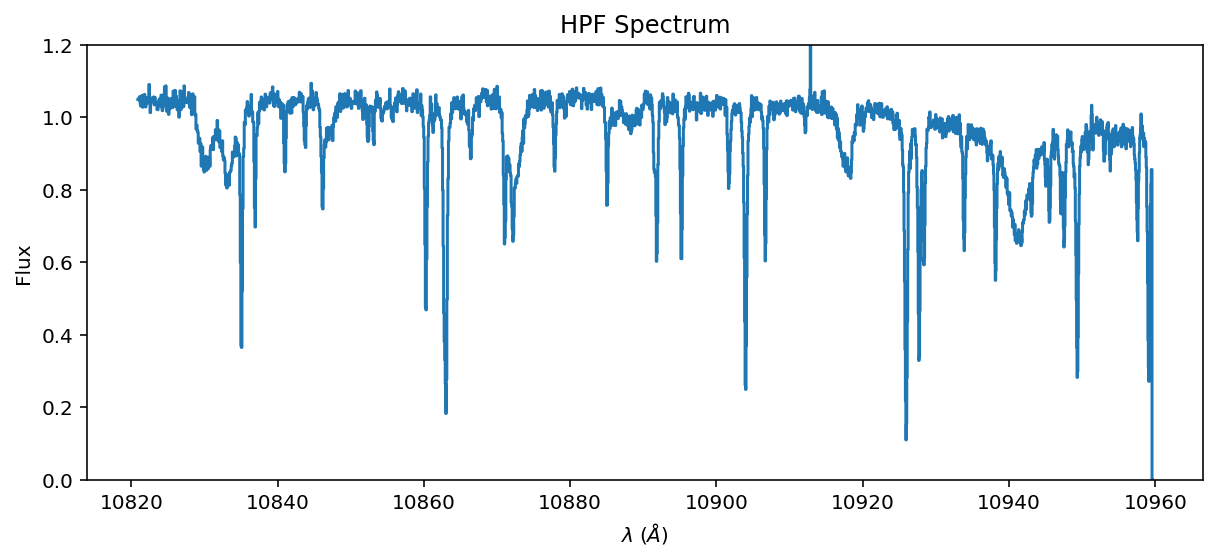

In [39]:
subtracted_spectrum = raw_spectrum.sky_subtract(method='vector').deblaze().normalize() #spectrum with sky lines
subtracted_spectrum.plot(ylo=0)

<AxesSubplot:title={'center':'HPF Spectrum'}, xlabel='$\\lambda \\;(\\AA)$', ylabel='Flux'>

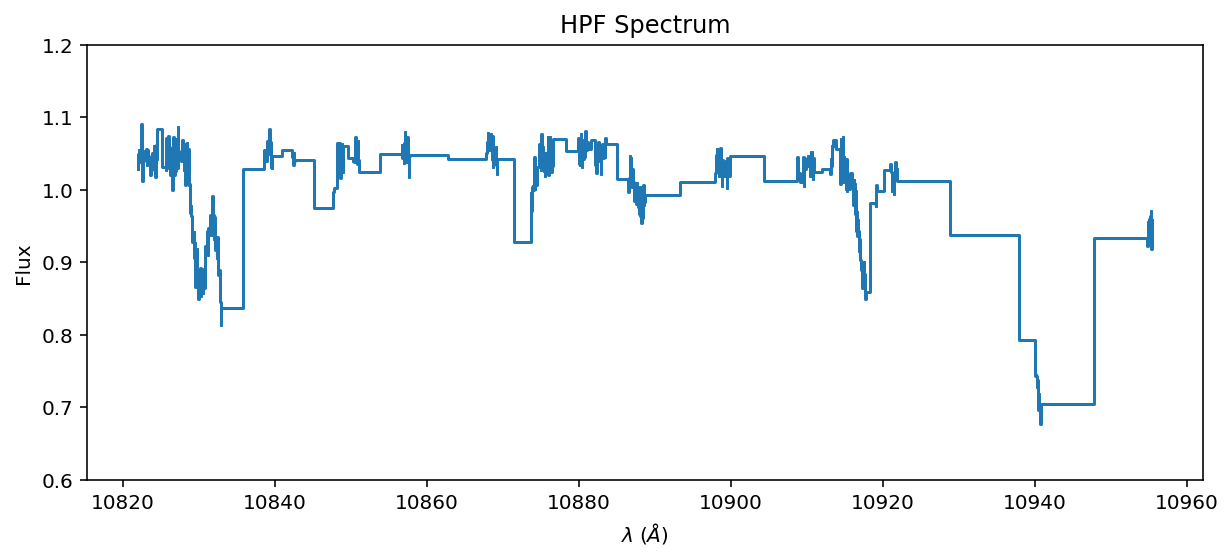

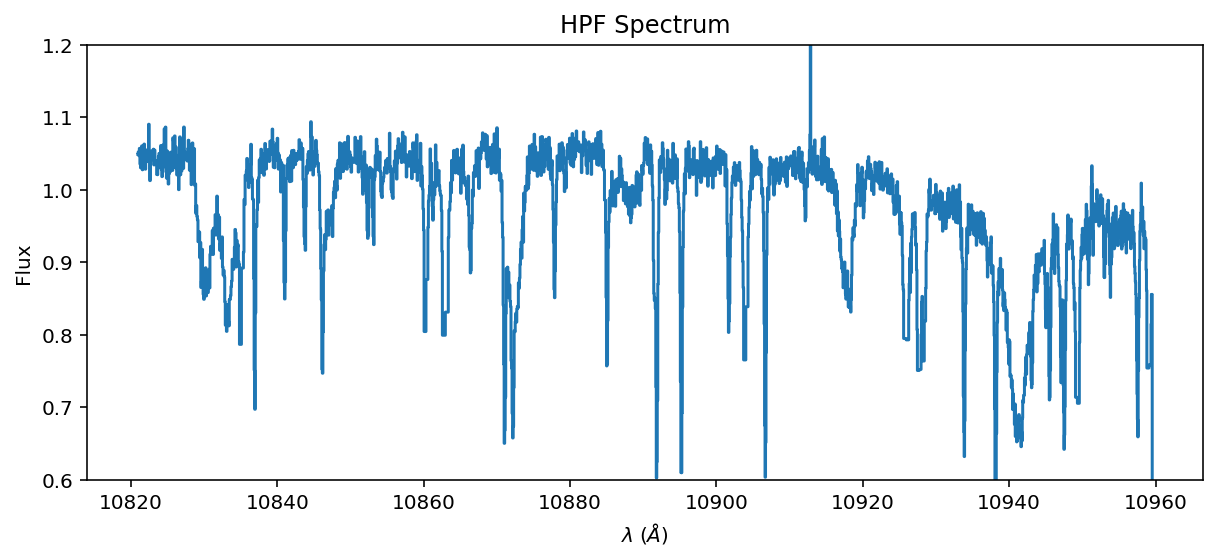

In [40]:
subtracted_spectrum.mask_tellurics(threshold=0.999,dilation=1).plot()
subtracted_spectrum.mask_tellurics(threshold=0.70,dilation=1).plot()

Let's make an observation log to group our spectra!

In [41]:
df = pd.read_csv('C:/Users/jojoa/GitHub/disperse/data/HPF_observing_log.csv')
mask = df.star_name.str.contains('67')
df = df[mask].reset_index(drop=True) #indecies go back to 0

In [11]:
df.star_name.value_counts() #all names for hat-p-67

HAT-P-67b_IN_2             14
HAT-P-67b_IN_1             14
hat-p-67b                  10
HAT-P-67b_IN_3              9
HAT-P-67b_OUT_same3         9
Hat-P-67                    4
HAT-P-67b_OUT_3_before1     4
HAT-P-67b_OUT_2_before1     4
HAT-P-67b_OUT_1_after1      4
HAT-P-67b_OUT_1_before1     4
HAT-P-67b_OUT_3_after1      4
HAT-P-67b_OUT_2_before2     4
HAT-P-67b_OUT_3_after2      4
HAT-P-67b_OUT_2_after1      4
HAT-P-67b_OUT_2_after2      4
HAT-P-67b_OUT_3_before2     3
Name: star_name, dtype: int64

Let's spot check if there were multiple visits in a singular night that were in an out of transit:

In [12]:
orbital_period = 4.81010250
t_c = 2455961.38467
t_c_btjd = t_c-2457000.0 #neg value means discovered before TESS

In [13]:
df['btjd']=df['jd']-2457000.0 #cut down JD to smaller scale
df['phase']=np.mod(df.btjd-t_c_btjd+(orbital_period*0.5),orbital_period)-0.5*orbital_period
df['normalized_phase']=(df['phase']/orbital_period) #centered at 0

In [14]:
df['in_transit']=np.abs(df.phase)<0.15
in_transit_mask=df['in_transit'].values

In [15]:
df

,date,dec,exp_time,jd,qidx,ra,star_name,time,btjd,phase,normalized_phase,in_transit
0,2021-02-24,44.761898,511.20,2.459270e+06,8486.0,17.106223,hat-p-67b,10:55:40,2269.955325,-0.779865,-0.162131,False
1,2021-02-24,44.761748,511.20,2.459270e+06,8486.0,17.106316,hat-p-67b,11:04:43,2269.961618,-0.773572,-0.160822,False
2,2020-04-28,44.763974,308.85,2.458968e+06,6437.0,17.106801,HAT-P-67b_IN_1,06:10:31,1967.757308,0.058575,0.012178,True
3,2020-04-28,44.763643,308.85,2.458968e+06,6437.0,17.106878,HAT-P-67b_IN_1,06:16:12,1967.761256,0.062523,0.012998,True
4,2020-04-28,44.763456,308.85,2.458968e+06,6437.0,17.106957,HAT-P-67b_IN_1,06:21:53,1967.765204,0.066472,0.013819,True
...,...,...,...,...,...,...,...,...,...,...,...,...
94,2021-02-01,44.762381,511.20,2.459247e+06,8486.0,17.106097,hat-p-67b,12:36:08,2247.025101,0.340424,0.070773,False
95,2021-02-26,44.762300,511.20,2.459272e+06,8486.0,17.106223,hat-p-67b,10:28:30,2271.936468,1.201278,0.249741,False
96,2021-02-26,44.762153,511.20,2.459272e+06,8486.0,17.106297,hat-p-67b,10:37:34,2271.942761,1.207571,0.251049,False
97,2021-03-04,44.762375,511.20,2.459278e+06,8486.0,17.106297,hat-p-67b,10:18:26,2277.929478,2.384186,0.495662,False


In [ ]:
df_merged['snr'] = [np.nanmedian(HPFSpectrum(file=fn, order=19).sky_subtract(method='vector').snr.value) 
                     for fn in df_merged['Path'].values]

In [16]:
df.groupby('date').in_transit.unique() #tells you which nights have in/out of transit
#6/15 has both in and out of transit

date
2020-04-27          [False]
2020-04-28           [True]
2020-04-29          [False]
2020-05-20          [False]
2020-05-21          [False]
2020-05-22           [True]
2020-05-23          [False]
2020-05-24          [False]
2020-06-13          [False]
2020-06-14          [False]
2020-06-15    [False, True]
2020-06-16          [False]
2020-06-18          [False]
2020-07-22          [False]
2020-08-01          [False]
2021-01-31          [False]
2021-02-01          [False]
2021-02-24          [False]
2021-02-26          [False]
2021-03-04          [False]
Name: in_transit, dtype: object

In [17]:
df.groupby('date').star_name.unique() #tells you which nights have in/out of transit
#6/15 has both in and out of transit on the same day with Jessica's labels

date
2020-04-27                [HAT-P-67b_OUT_1_before1]
2020-04-28                         [HAT-P-67b_IN_1]
2020-04-29                 [HAT-P-67b_OUT_1_after1]
2020-05-20                [HAT-P-67b_OUT_2_before2]
2020-05-21                [HAT-P-67b_OUT_2_before1]
2020-05-22                         [HAT-P-67b_IN_2]
2020-05-23                 [HAT-P-67b_OUT_2_after1]
2020-05-24                 [HAT-P-67b_OUT_2_after2]
2020-06-13                [HAT-P-67b_OUT_3_before2]
2020-06-14                [HAT-P-67b_OUT_3_before1]
2020-06-15    [HAT-P-67b_IN_3, HAT-P-67b_OUT_same3]
2020-06-16                 [HAT-P-67b_OUT_3_after1]
2020-06-18                 [HAT-P-67b_OUT_3_after2]
2020-07-22                               [Hat-P-67]
2020-08-01                               [Hat-P-67]
2021-01-31                              [hat-p-67b]
2021-02-01                              [hat-p-67b]
2021-02-24                              [hat-p-67b]
2021-02-26                              [hat-p-67b]
2021-03

In [18]:
mask = df.date.str.contains('2020-06-15')

In [19]:
df_june = df[mask].reset_index(drop=True) #shows out of transit to in from 3:30-3:36

In [20]:
df_june

,date,dec,exp_time,jd,qidx,ra,star_name,time,btjd,phase,normalized_phase,in_transit
0,2020-06-15,44.768164,308.85,2.459016e+06,6938.0,17.106909,HAT-P-67b_IN_3,03:13:19,2015.634256,-0.165501,-0.034407,False
1,2020-06-15,44.767792,308.85,2.459016e+06,6938.0,17.106979,HAT-P-67b_IN_3,03:19:00,2015.638204,-0.161553,-0.033586,False
2,2020-06-15,44.767746,308.85,2.459016e+06,6938.0,17.107035,HAT-P-67b_IN_3,03:24:41,2015.642153,-0.157605,-0.032765,False
3,2020-06-15,44.767580,308.85,2.459016e+06,6938.0,17.107103,HAT-P-67b_IN_3,03:30:23,2015.646101,-0.153657,-0.031945,False
4,2020-06-15,44.767436,308.85,2.459016e+06,6938.0,17.107145,HAT-P-67b_IN_3,03:36:04,2015.650049,-0.149708,-0.031124,True
5,2020-06-15,44.767252,308.85,2.459016e+06,6938.0,17.107246,HAT-P-67b_IN_3,03:41:45,2015.653998,-0.145760,-0.030303,True
6,2020-06-15,44.767175,308.85,2.459016e+06,6938.0,17.107295,HAT-P-67b_IN_3,03:47:26,2015.657946,-0.141811,-0.029482,True
7,2020-06-15,44.766835,308.85,2.459016e+06,6938.0,17.107368,HAT-P-67b_IN_3,03:53:07,2015.661894,-0.137863,-0.028661,True
8,2020-06-15,44.766759,308.85,2.459016e+06,6938.0,17.107418,HAT-P-67b_IN_3,03:58:48,2015.665843,-0.133915,-0.027840,True
9,2020-06-15,44.783524,308.85,2.459016e+06,6943.0,17.107765,HAT-P-67b_OUT_same3,08:59:57,2015.874976,0.075219,0.015638,True


In [21]:
#parse list of strings
base_name = [fn.split('\\')[-1] for fn in goldilocks_files]#gives just filename for -1 entry
base_name

['Goldilocks_20200615T031252_v1.0_0023.spectra.fits',
 'Goldilocks_20200615T031831_v1.0_0024.spectra.fits',
 'Goldilocks_20200615T032417_v1.0_0025.spectra.fits',
 'Goldilocks_20200615T032955_v1.0_0026.spectra.fits',
 'Goldilocks_20200615T033540_v1.0_0027.spectra.fits',
 'Goldilocks_20200615T034120_v1.0_0028.spectra.fits',
 'Goldilocks_20200615T034659_v1.0_0029.spectra.fits',
 'Goldilocks_20200615T035238_v1.0_0030.spectra.fits',
 'Goldilocks_20200615T035824_v1.0_0031.spectra.fits',
 'Goldilocks_20200615T085929_v1.0_0060.spectra.fits',
 'Goldilocks_20200615T090514_v1.0_0061.spectra.fits',
 'Goldilocks_20200615T091054_v1.0_0062.spectra.fits',
 'Goldilocks_20200615T091633_v1.0_0063.spectra.fits',
 'Goldilocks_20200615T092218_v1.0_0064.spectra.fits',
 'Goldilocks_20200615T092758_v1.0_0065.spectra.fits',
 'Goldilocks_20200615T093338_v1.0_0066.spectra.fits',
 'Goldilocks_20200615T093917_v1.0_0067.spectra.fits',
 'Goldilocks_20200615T094457_v1.0_0068.spectra.fits']

In [22]:
df_base = pd.DataFrame({'base_name':base_name,'full_path':goldilocks_files}) #must give a dictionary aka list

In [23]:
df_june = pd.concat([df_june,df_base],axis=1) 

We now have a dataframe with the filename and time!

In [24]:
multi_spec = []
for i in range(len(df_june)):
    fn = df_june.full_path[i]
    raw_spectrum = HPFSpectrum(file=fn,order=19)
    clean_spectrum = raw_spectrum.sky_subtract(method='vector').deblaze().normalize()
    clean_spectrum = clean_spectrum.trim_edges((4,2042)) #spectrum without nans
    multi_spec.append(clean_spectrum)

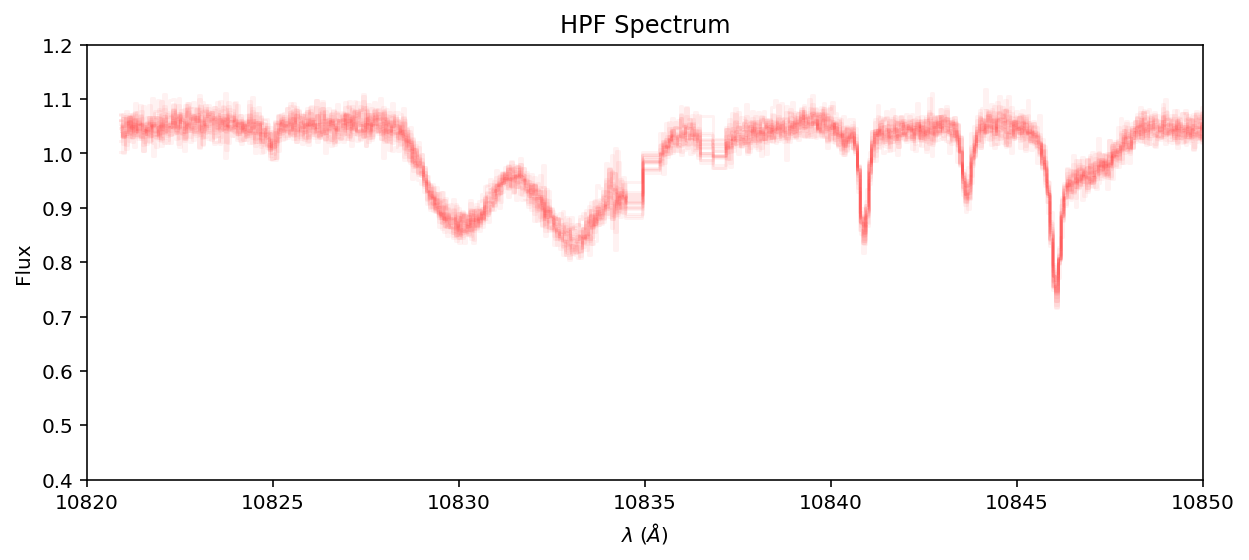

In [25]:
#overplotted all spectra from one night
spectrum = multi_spec[8] #shows tellurics
ax = spectrum.plot(alpha=0)
ax.set_xlim(10820,10850)
ax.set_ylim(0.4,1.2)

for i in range(len(multi_spec)):
    spectrum = multi_spec[i]
    spectrum = spectrum.mask_tellurics(threshold=0.8,dilation=3).barycentric_correct() #removes telluric lines from spectra
    spectrum.plot(ax=ax,alpha=0.05,color='r')

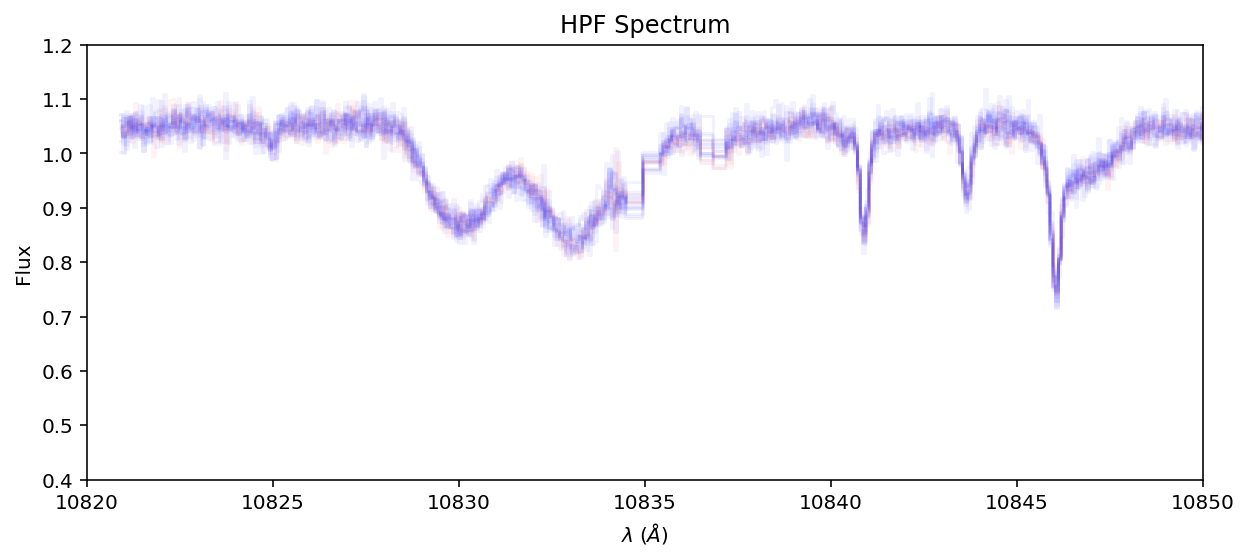

In [26]:
spectrum = multi_spec[8] #shows tellurics
ax = spectrum.plot(alpha=0)
ax.set_xlim(10820,10850)
ax.set_ylim(0.4,1.2)

for i in range(0,4):
    spectrum = multi_spec[i]
    spectrum = spectrum.mask_tellurics(threshold=0.8,dilation=3).barycentric_correct() #removes telluric lines from spectra
    spectrum.plot(ax=ax,alpha=0.05,color='r') #out of transit
    
for i in range(4,len(multi_spec)):
    spectrum = multi_spec[i]
    spectrum = spectrum.mask_tellurics(threshold=0.8,dilation=3).barycentric_correct() #removes telluric lines from spectra
    spectrum.plot(ax=ax,alpha=0.05,color='b') #in transit

HAVE NOT DONE YET:

In [27]:
normalization_term = raw_spectrum[10822.5*u.Angstrom:10827.5*u.Angstrom].flux.mean()
spectrum = raw_spectrum.divide(normalization_term, handle_meta='ff')

In [28]:
spectrum = spectrum.barycentric_correct()

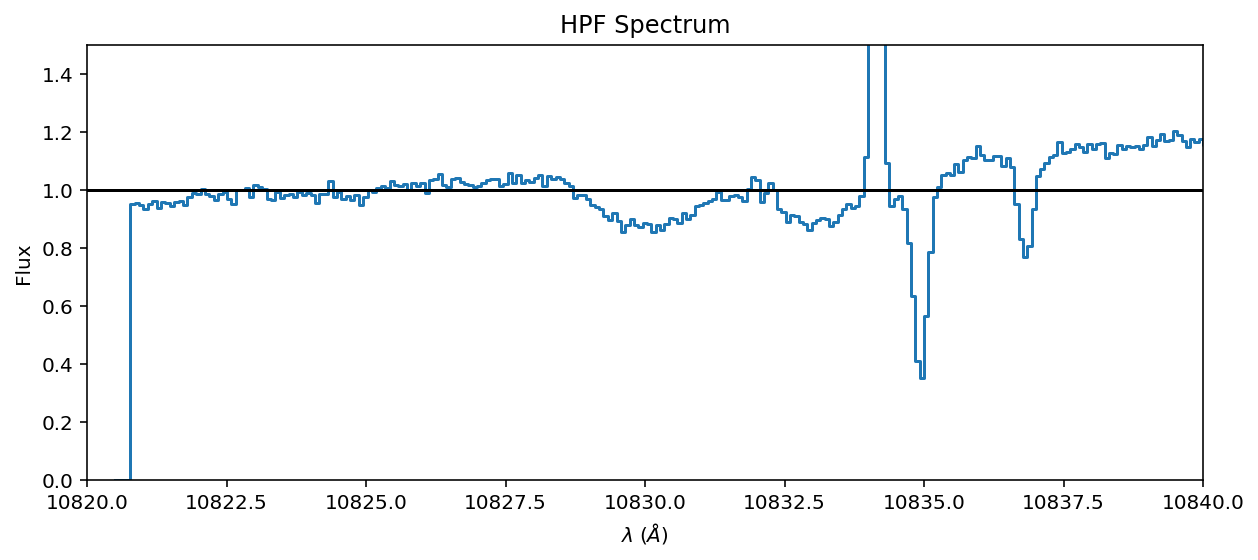

In [29]:
ax = spectrum.plot()
ax.set_ylim(0,1.5)
ax.set_xlim(10820,10840)
ax.axhline(1.0,color='k')

In [30]:
from specutils.analysis import equivalent_width
from specutils.spectra import SpectralRegion

In [46]:
ew = equivalent_width(spectrum, continuum=1, regions=SpectralRegion(10827.5*u.angstrom, 10832.5*u.angstrom))

In [47]:
#spectrum = raw_spectrum.sky_subtract(method='vector') #wavelength dependent

In [48]:
ew

<Quantity 0.12464884 Angstrom>